# Comparing and Evaluating Clustering Algorithms

### Adjusted Rand Index (ARI)

In [2]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from sklearn.metrics import accuracy_score

Comparing random assignment, k-means, agglomerative clustering, and DBSCAN on the two_moons dataset using the supervised ARI score

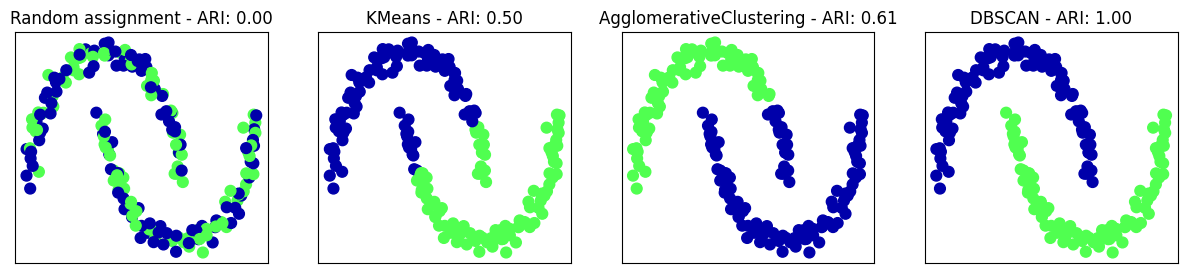

In [3]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X) # compute the mean and standard deviation of the data
X_scaled = scaler.transform(X) # rescale the data
fig, axes = plt.subplots(1, 4, figsize=(15, 3),subplot_kw={'xticks': (), 'yticks': ()})
# make a list of algorithms to use
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),DBSCAN()]
# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))
# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
adjusted_rand_score(y, random_clusters)))
for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
    cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,adjusted_rand_score(y, clusters)))

A common mistake when evaluating clustering in this way is to use `accuracy_score` instead of `adjusted_rand_score`, `normalized_mutual_info_score`, or some other clustering metric. The problem in using accuracy is that it requires the assigned cluster labels to exactly match the ground truth.

In [5]:
# these two labelings of points correspond to the same clustering
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]
# accuracy is zero, as none of the labels are the same
print(f"Accuracy: {accuracy_score(clusters1, clusters2):.2f}")
# adjusted rand score is 1, as the clustering is exactly the same
print(f"ARI: {adjusted_rand_score(clusters1, clusters2):.2f}")

Accuracy: 0.00
ARI: 1.00


### Evaluating clustering without ground truth


Comparing random assignment, k-means, agglomerative clustering, andDBSCAN on the two_moons dataset using the unsupervised silhouette score—the more intuitive result of DBSCAN has a lower silhouette score than the assignments found by k-means

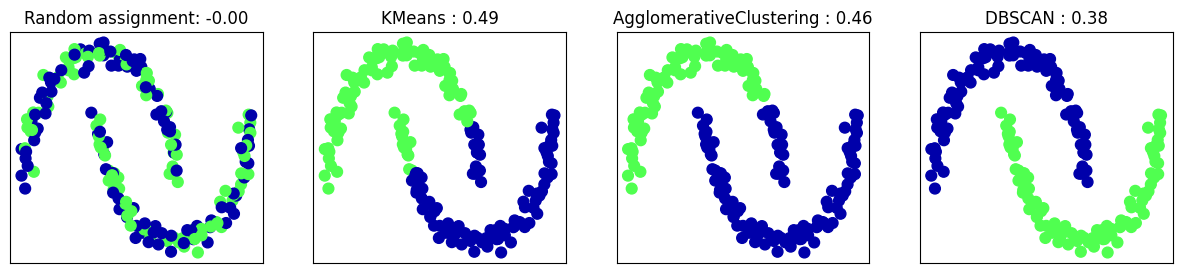

In [6]:
from sklearn.metrics.cluster import silhouette_score
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
fig, axes = plt.subplots(1, 4, figsize=(15, 3),
subplot_kw={'xticks': (), 'yticks': ()})
# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))
# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
cmap=mglearn.cm3, s=60)
axes[0].set_title(f"Random assignment: {silhouette_score(X_scaled, random_clusters):.2f}")
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
DBSCAN()]
for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3,s=60)
    ax.set_title(f"{algorithm.__class__.__name__} : {silhouette_score(X_scaled, clusters):.2f}")

Even if we get a very robust clustering, or a very high silhouette score, we still don’t know if there is any semantic meaning in the clustering

### Comparing algorithms on the faces dataset

In [7]:
# extract eigenfaces from lfw data and transform data
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
# load the data
people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X_people = people.data
y_people = people.target
pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)

In [9]:
# apply DBSCAN with default parameters
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print(f"Unique labels: {np.unique(labels)}")

Unique labels: [-1]


We see that all the returned labels are –1, so all of the data was labeled as “noise” by DBSCAN. There are two things we can change to help this: we can make eps higher, to expand the neighborhood of each point, and set min_samples lower, to consider smaller groups of points as clusters. Let’s try changing min_samples first

In [10]:
dbscan = DBSCAN(min_samples=3)
labels = dbscan.fit_predict(X_pca)
print(f"Unique labels: {np.unique(labels)}")

Unique labels: [-1]


In [11]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1  0]


Using a much larger eps of 15, we get only a single cluster and noise points. We can use this result to find out what the “noise” looks like compared to the rest of the data

In [12]:
# Count number of points in all clusters and noise.
# bincount doesn't allow negative numbers, so we need to add 1.
# The first number in the result corresponds to noise points.
print(f"Number of points per cluster: {np.bincount(labels + 1)}")

Number of points per cluster: [  26 1262]


In [ ]:
noise = X_people[labels==-1]
fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()},
figsize=(12, 4))
image_shape = people.images.shape[1:]
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)